# testAPI_propane

Created by Davy Yue 2017-06-22


### Imports

In [ ]:
import itertools
import string
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from msibi import MSIBI, State, Pair, mie
import mdtraj as md

## PROPANE - edition (code to be expanded)  ==============================

Where the real magic happens

In [ ]:
t = md.load('traj_unwrapped.dcd', top='start_aa.hoomdxml')

### Mapping and application

Keys being CG bead indices and values being a list of atom indices corresponding to each CG bead

e.g., {prop0: [0, 1, 2], prop1: [3, 4, 5], prop2: [6, 7, 8], …}

Construct for entire system

In [ ]:
cg_idx = 0
start_idx = 0
n_propane = 1024 #passed later
propane_map = {0: [0, 1, 2]}
system_mapping = {}
for n in range(n_propane):
    for bead, atoms in propane_map.items():
        system_mapping[cg_idx] = [x + start_idx for x in atoms]
        start_idx += len(atoms)
        cg_idx += 1
         
# print(system_mapping)

With mapping for whole system, apply to all atom trajectory

In [ ]:
from mdtraj.core import element
list(t.top.atoms)[0].element = element.carbon
list(t.top.atoms)[0].element.mass
for atom in t.top.atoms:
    atom.element = element.carbon

In [ ]:
cg_xyz = np.empty((t.n_frames, len(system_mapping), 3))
for cg_bead, aa_indices in system_mapping.items():
    cg_xyz[:, cg_bead, :] = md.compute_center_of_mass(t.atom_slice(aa_indices))
    
# print(cg_xyz)

### Traj & Obj

* Create new Trajectory object & CG Topology object

* Save resultant trajectory file

In [ ]:
cg_top = md.Topology()
for cg_bead in system_mapping.keys():
    cg_top.add_atom('carbon', element.virtual_site, cg_top.add_residue('A', cg_top.add_chain())) 
    
cg_traj = md.Trajectory(cg_xyz, cg_top, time=None, unitcell_lengths=t.unitcell_lengths, unitcell_angles=t.unitcell_angles)
cg_traj.save_dcd('cg_traj.dcd')

# print(cg_traj)
# print(cg_top)
# print(cg_xyz)

### Calculate RDF and save

In [ ]:
pairs = cg_traj.top.select_pairs(selection1='name "carbon"', selection2='name "carbon"')

# mdtraj.compute_rdf(traj, pairs=None, r_range=None, bin_width=0.005, n_bins=None, periodic=True, opt=True)
r, g_r = md.compute_rdf(cg_traj, pairs=pairs, r_range=(0, 1.2), bin_width=0.005)
np.savetxt('rdfs_aa.txt', np.transpose([r, g_r]))

In [ ]:
fig, ax = plt.subplots()
ax.plot(r, g_r)
ax.set_xlabel("r")
ax.set_ylabel("g(r)")

## Testing for Conversion into Function/Class ==============================

Code May Break At Anytime

In [ ]:
# 2017_06_26 4:00 PM CST
# **** DEBUGGING/TESTING NOTES ****
# - wrap above code in a function
# - print the plot in one line
# - think about inputs and outputs
# - think about where variables can be passed as parameters
# - need test cases - maybe with n-dodecane
# - check with generated rdfs from above to compare results
# - maybe use more functions to call
# - consider adaptation for other organic molecules 
#      (carbon, hydrogen, nitrogen, oxygen, phosphorus, and sulfur)
#      CHNOP
# - need ability to have multiple elements (later testing phase)

In [2]:
import itertools
import string
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from msibi import MSIBI, State, Pair, mie
import mdtraj as md

NameError: name 'ax' is not defined

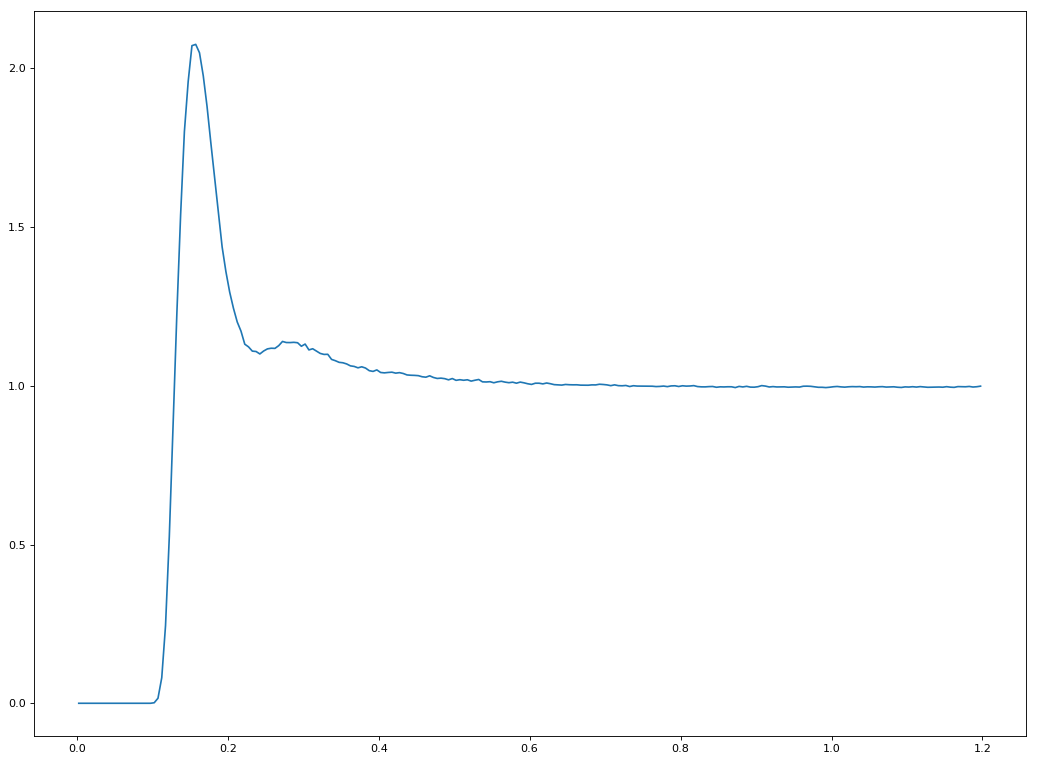

In [3]:
filename_traj = ''

t = md.load('traj_unwrapped.dcd', top='start_aa.hoomdxml')

# ******

cg_idx = 0
start_idx = 0
n_propane = 1024 #passed later as parameter
propane_map = {0: [0, 1, 2]} # need better mapping definition
system_mapping = {}
for n in range(n_propane):
    for bead, atoms in propane_map.items():
        system_mapping[cg_idx] = [x + start_idx for x in atoms]
        start_idx += len(atoms)
        cg_idx += 1

# ************************************************************

from mdtraj.core import element
list(t.top.atoms)[0].element = element.carbon # check element
list(t.top.atoms)[0].element.mass
for atom in t.top.atoms:
    atom.element = element.carbon # check element

# ************************************************************

cg_xyz = np.empty((t.n_frames, len(system_mapping), 3))
for cg_bead, aa_indices in system_mapping.items():
    cg_xyz[:, cg_bead, :] = md.compute_center_of_mass(t.atom_slice(aa_indices))

# ************************************************************

cg_top = md.Topology()
for cg_bead in system_mapping.keys(): #i got the keys keys keys
    cg_top.add_atom('carbon', element.virtual_site, cg_top.add_residue('A', 
                        cg_top.add_chain())) 
    
cg_traj = md.Trajectory(cg_xyz, cg_top, time=None, unitcell_lengths=t.unitcell_lengths, 
                        unitcell_angles=t.unitcell_angles)
cg_traj.save_dcd('cg_traj.dcd') # need check statements to prevent file overwrite

# ************************************************************

pairs = cg_traj.top.select_pairs(selection1='name "carbon"', selection2='name "carbon"')

# mdtraj.compute_rdf(traj, pairs=None, r_range=None, bin_width=0.005, n_bins=None, periodic=True, opt=True)
r, g_r = md.compute_rdf(cg_traj, pairs=pairs, r_range=(0, 1.2), bin_width=0.005) #identify end of range with data pairs
np.savetxt('rdfs_aa.txt', np.transpose([r, g_r])) # need check statements to prevent file overwrite

# ************************************************************

plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot(r, g_r, label="CG Propane")

plt.xlabel("r")
plt.ylabel("g(r)")
plt.legend()

# ************************************************************


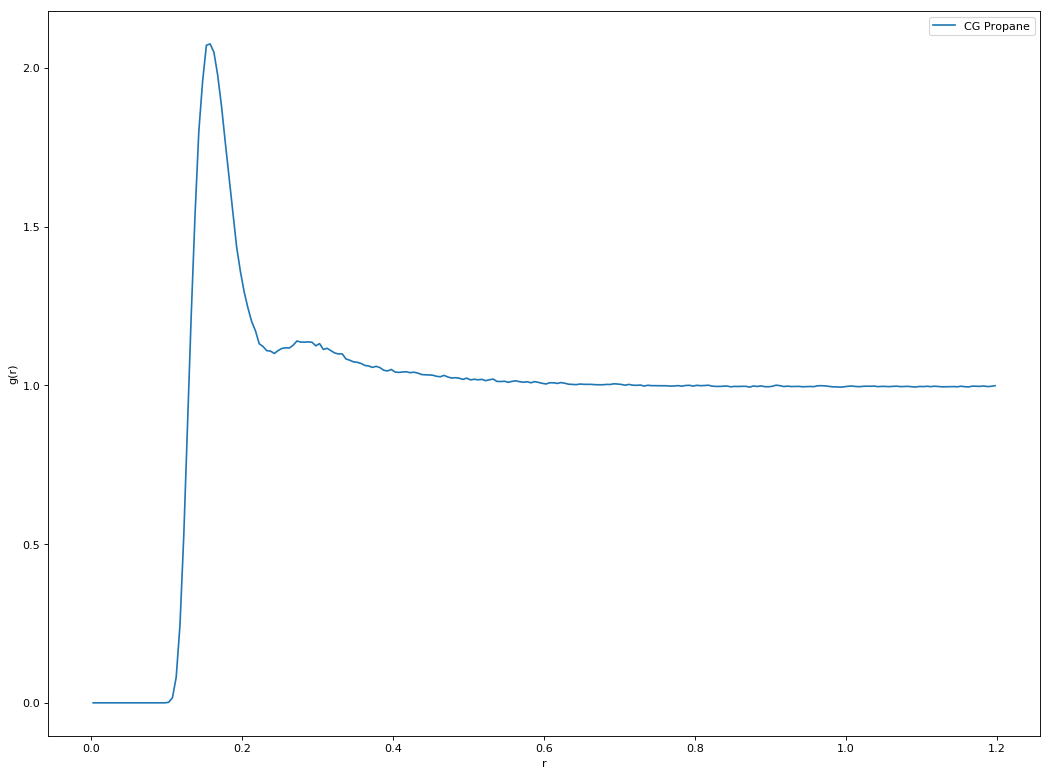

In [4]:
plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot(r, g_r, label="CG Propane")

plt.xlabel("r")
plt.ylabel("g(r)")
plt.legend()
